In [ ]:
#importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from keras.preprocessing import image
import keras
import xgboost

In [ ]:
#loading the training data in the form of Pandas DataFrame
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_path         1399 non-null   object 
 1   Insurance_company  1399 non-null   object 
 2   Cost_of_vehicle    1310 non-null   float64
 3   Min_coverage       1310 non-null   float64
 4   Expiry_date        1399 non-null   object 
 5   Max_coverage       1310 non-null   float64
 6   Condition          1399 non-null   int64  
 7   Amount             1388 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 87.6+ KB


In [ ]:
#describes the statistics of the training data
df_train.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
count,1310.000000,1310.000000,1310.000000,1399.000000,1388.000000
mean,37454.274809,936.356870,11242.925160,0.929235,4117.144092
std,8921.428143,223.035704,7163.735952,0.256523,3151.516223
min,11100.000000,277.500000,2853.000000,0.000000,-999.000000
25%,29800.000000,745.000000,7603.000000,1.000000,1641.750000
50%,37300.000000,932.500000,9678.000000,1.000000,4070.000000
75%,45175.000000,1129.375000,11703.000000,1.000000,6039.500000
max,53500.000000,1337.500000,46495.680000,1.000000,59844.000000


There is some anomaly in the amount data i.e. negative value.

In [ ]:
#Checking for all the samples with negative value of amount
for i in range(df_train.shape[0]):
    if (df_train.iloc[i]['Amount'] < 0):
        print(i)
        print(df_train.iloc[i])

641
Image_path           img_7766741.jpg
Insurance_company                  O
Cost_of_vehicle                  NaN
Min_coverage                     NaN
Expiry_date               2028-01-31
Max_coverage                     NaN
Condition                          1
Amount                          -999
Name: 641, dtype: object


As we can the sample has very less information so we can remove it from our dataframe

In [ ]:
#removing the sample with negattive value
df_train = df_train.drop(labels = 641)
df_train.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
count,1310.000000,1310.000000,1310.000000,1398.000000,1387.000000
mean,37454.274809,936.356870,11242.925160,0.929185,4120.832733
std,8921.428143,223.035704,7163.735952,0.256608,3149.654210
min,11100.000000,277.500000,2853.000000,0.000000,0.000000
25%,29800.000000,745.000000,7603.000000,1.000000,1656.500000
50%,37300.000000,932.500000,9678.000000,1.000000,4071.000000
75%,45175.000000,1129.375000,11703.000000,1.000000,6040.000000
max,53500.000000,1337.500000,46495.680000,1.000000,59844.000000


In [ ]:
#displays all the samples with 'Condition'= 0 (Cars that are not damaged)
df_train[df_train['Condition']== 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 1377
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_path         99 non-null     object 
 1   Insurance_company  99 non-null     object 
 2   Cost_of_vehicle    97 non-null     float64
 3   Min_coverage       97 non-null     float64
 4   Expiry_date        99 non-null     object 
 5   Max_coverage       97 non-null     float64
 6   Condition          99 non-null     int64  
 7   Amount             99 non-null     float64
dtypes: float64(4), int64(1), object(3)
memory usage: 7.0+ KB


As the amount for non damaged cars is 0 so for our regression task we will only consider the samples with damaged cars

In [ ]:
#taking only the samples with 'Condition'= 1 (damaged cars) for regression 
df_train = df_train[df_train['Condition']== 1]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 1 to 1398
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_path         1299 non-null   object 
 1   Insurance_company  1299 non-null   object 
 2   Cost_of_vehicle    1213 non-null   float64
 3   Min_coverage       1213 non-null   float64
 4   Expiry_date        1299 non-null   object 
 5   Max_coverage       1213 non-null   float64
 6   Condition          1299 non-null   int64  
 7   Amount             1288 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 91.3+ KB


In [ ]:
#dropping the features which are not required for our regression task
df_train = df_train.drop(['Image_path', 'Expiry_date', 'Condition'], axis= 1)
df_train.head()

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Amount
1,BQ,50700.0,1267.5,12753.0,6194.0
3,A,33500.0,837.5,8453.0,7699.0
4,AC,27600.0,690.0,6978.0,8849.0
5,AC,50700.0,1267.5,12753.0,253.0
6,AC,53200.0,1330.0,13378.0,4013.0


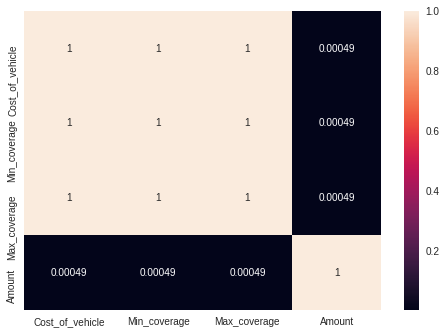

In [ ]:
#gives the heatmap of correlation values among different features of the traing data
correlation_matrix = df_train.corr()
plt.style.use('seaborn')
sns.heatmap(data= correlation_matrix, annot= True)

As we can see '**Cost_of_vehicle**', '**Min_coverage**' and '**Max_coverage**' features have correlation value of 1 among themselves so we can take any one of them our regression task.

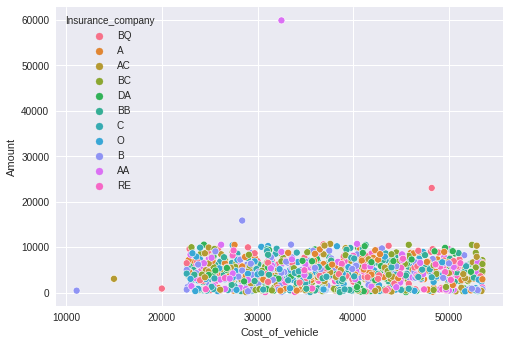

In [ ]:
#shows distribution of datapoints between 'Cost_of_vehicle' and 'Amount'
#different colors are used for datapoints of different indurance companies
sns.scatterplot(x= df_train['Cost_of_vehicle'], y= df_train['Amount'], hue= df_train['Insurance_company'])

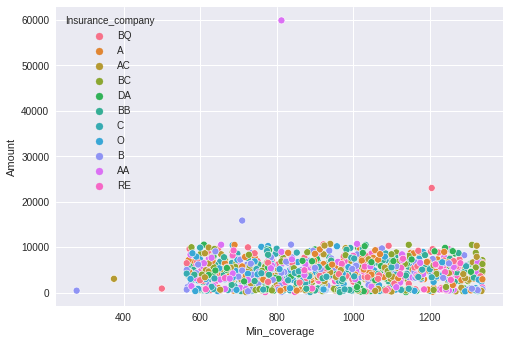

In [ ]:
#shows distribution of datapoints between 'Min_coverage' and 'Amount'
#different colors are used for datapoints of different indurance companies
sns.scatterplot(x= df_train['Min_coverage'], y= df_train['Amount'], hue= df_train['Insurance_company'])

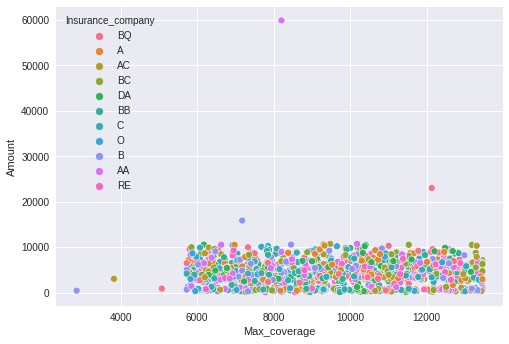

In [ ]:
#shows distribution of datapoints between 'Max_coverage' and 'Amount'
#different colors are used for datapoints of different indurance companies
sns.scatterplot(x= df_train['Max_coverage'], y= df_train['Amount'], hue= df_train['Insurance_company'])

As we can see without considering the outliers samples the range of amount data is fairly close to range of Max_coverage . So we can drop '**Cost_of_vehile**' and '**Min_coverage**' features and use '**Max_coverage**' for prediction.

In [ ]:
#getting the indexes of outliers
indices = df_train[df_train['Amount']> 11000].index.values.astype(int)
indices

array([ 786,  955, 1324])

In [ ]:
#removing the outliers
df_train = df_train.drop(labels= indices, axis= 0)

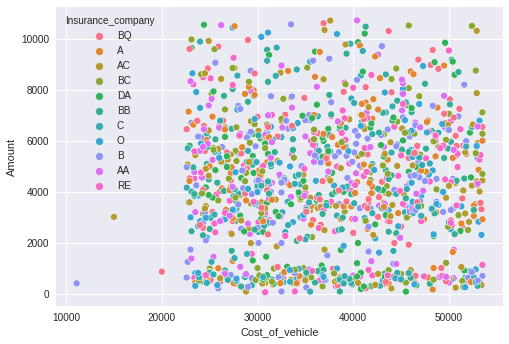

In [ ]:
#shows distribution of datapoints between 'Cost_of_vehicle' and 'Amount' after removing the outliers
#different colors are used for datapoints of different indurance companies
sns.scatterplot(x= df_train['Cost_of_vehicle'], y= df_train['Amount'], hue= df_train['Insurance_company'])

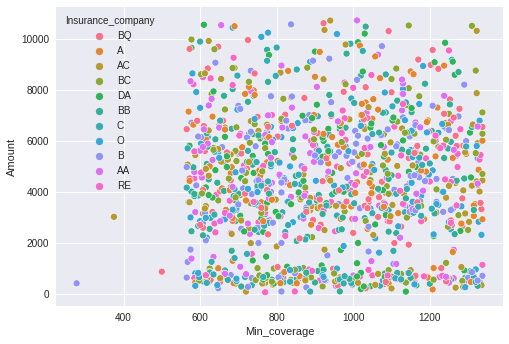

In [ ]:
#shows distribution of datapoints between 'Min_coverage' and 'Amount' after removing the outliers
#different colors are used for datapoints of different indurance companies
sns.scatterplot(x= df_train['Min_coverage'], y= df_train['Amount'], hue= df_train['Insurance_company'])

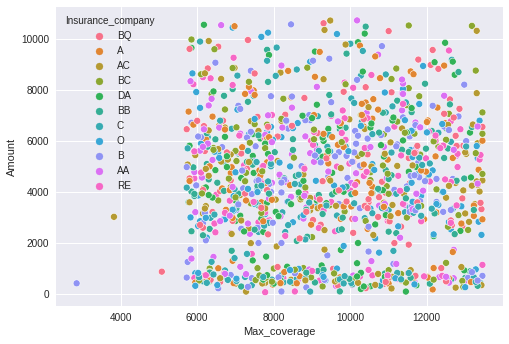

In [ ]:
#shows distribution of datapoints between 'Min_coverage' and 'Amount' after removing the outliers
#different colors are used for datapoints of different indurance companies
sns.scatterplot(x= df_train['Max_coverage'], y= df_train['Amount'], hue= df_train['Insurance_company'])

In [ ]:
#dropping the 'Cost_of_vehicle' and 'Min_coverage' features
df_train= df_train.drop(['Cost_of_vehicle', 'Min_coverage'], axis= 1)
df_train.head()

,Insurance_company,Max_coverage,Amount
1,BQ,12753.0,6194.0
3,A,8453.0,7699.0
4,AC,6978.0,8849.0
5,AC,12753.0,253.0
6,AC,13378.0,4013.0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1398
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Insurance_company  1296 non-null   object 
 1   Max_coverage       1210 non-null   float64
 2   Amount             1285 non-null   float64
dtypes: float64(2), object(1)
memory usage: 40.5+ KB


We can se there are some missing values in the '**Max_coverage**' and '**Amount**' columns.

In [ ]:
df_train.describe()

,Max_coverage,Amount
count,1210.000000,1285.000000
mean,9405.190083,4371.140078
std,2226.981176,2556.095162
min,2853.000000,74.000000
25%,7484.250000,2695.000000
50%,9328.000000,4349.000000
75%,11328.000000,6166.000000
max,13453.000000,10709.000000


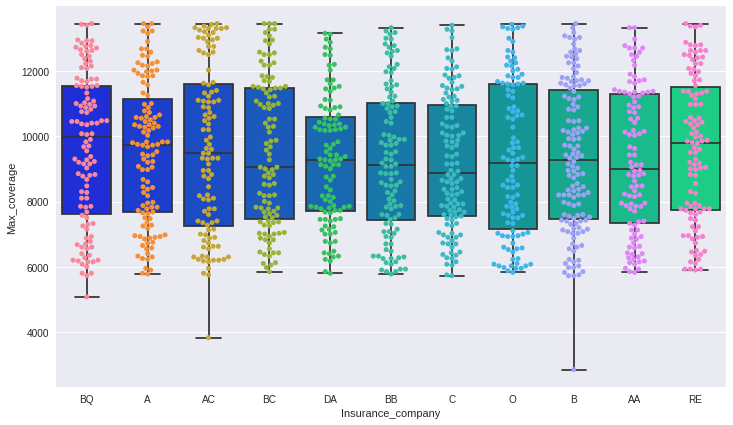

In [ ]:
#shows range of the values of 'Max_coverage' feature for different insurance companies
plt.figure(figsize=(12,7))
sns.boxplot(x = 'Insurance_company', y = 'Max_coverage', data = df_train, palette = 'winter')
sns.swarmplot(x = 'Insurance_company', y = 'Max_coverage', data = df_train, size = 5)

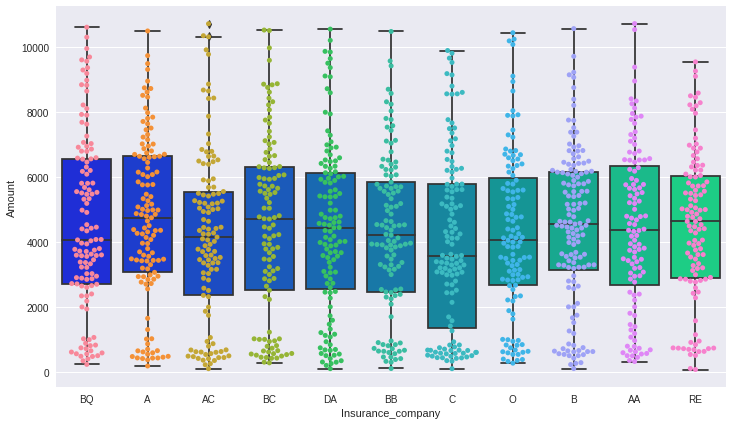

In [ ]:
#shows range of the values of amount(target feature) for different insurance companies
plt.figure(figsize=(12,7))
sns.boxplot(x = 'Insurance_company', y = 'Amount', data = df_train, palette = 'winter')
sns.swarmplot(x = 'Insurance_company', y = 'Amount', data = df_train, size = 5)

In [ ]:
#gives count of datapoints for each of the insurance companies
df_train['Insurance_company'].value_counts()

B     139
C     123
A     121
DA    120
BQ    118
O     116
BB    114
AC    113
BC    111
RE    111
AA    110
Name: Insurance_company, dtype: int64

We can see there is fairly good amount of distribution of data points wrt to each insurance companies. So the data is almost balanced wrt to insurance company

In [ ]:
#loading the test dataset after adding the 'Condition' column with the predictions from the image classification model
df_test = pd.read_csv('/content/test_c.csv')
df_test.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition
0,img_4538519.jpg,B,23600,590.0,2025-04-12,5978.0,1
1,img_7766002.jpg,C,28300,707.5,2028-08-24,7153.0,1
2,img_4637390.jpg,AC,43700,1092.5,2023-11-28,11003.0,1
3,img_4516108.jpg,BB,46100,1152.5,2028-02-04,11603.0,1
4,img_4517008.jpg,BB,40700,1017.5,2022-01-03,10253.0,1


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_path         600 non-null    object 
 1   Insurance_company  600 non-null    object 
 2   Cost_of_vehicle    600 non-null    int64  
 3   Min_coverage       600 non-null    float64
 4   Expiry_date        600 non-null    object 
 5   Max_coverage       600 non-null    float64
 6   Condition          600 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 32.9+ KB


In [ ]:
df_test.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition
count,600.000000,600.000000,600.000000,600.000000
mean,38175.500000,954.387500,11281.169267,0.975000
std,9181.904052,229.547601,6804.330322,0.156255
min,20000.000000,500.000000,5078.000000,0.000000
25%,30600.000000,765.000000,7990.500000,1.000000
50%,37650.000000,941.250000,9703.000000,1.000000
75%,46000.000000,1150.000000,12084.250000,1.000000
max,79200.000000,1980.000000,45451.680000,1.000000


In [ ]:
print('Train: ', sorted(df_train['Insurance_company'].unique()))
print('Test: ', sorted(df_test['Insurance_company'].unique()))

Train:  ['A', 'AA', 'AC', 'B', 'BB', 'BC', 'BQ', 'C', 'DA', 'O', 'RE']
Test:  ['A', 'AA', 'AC', 'B', 'BB', 'BC', 'BQ', 'C', 'DA', 'O', 'RE']


As we can the testing and training datasets contain same insurance companies otherwise we had to adjust out datasets accordingly for label_encoding purposes

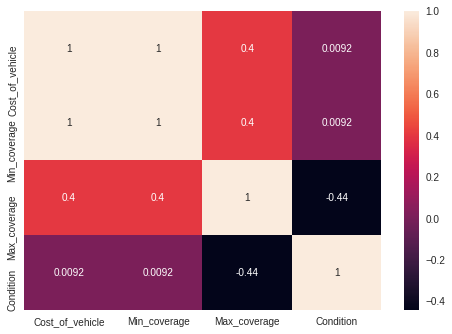

In [ ]:
correlation_matrix = df_test.corr()
plt.style.use('seaborn')
sns.heatmap(data = correlation_matrix, annot= True)

As we can see there are no missing values in the test dataset so need for any feature engineering on testing dataset as such for now.

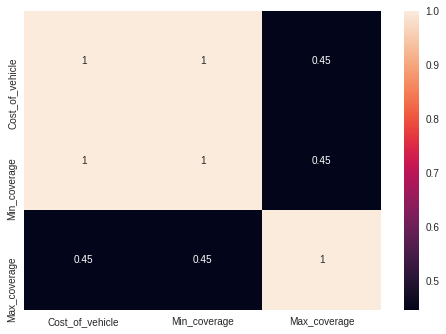

In [ ]:
correlation_matrix = df_test[df_test['Condition']== 1].drop('Condition', axis= 1).corr()
plt.style.use('seaborn')
sns.heatmap(data = correlation_matrix, annot= True)

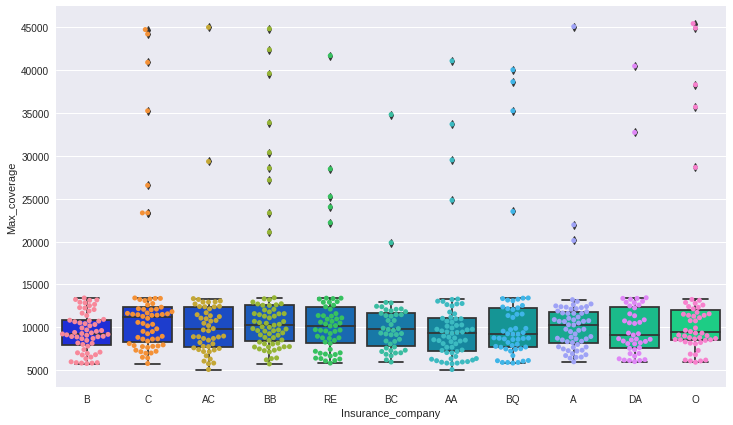

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x = 'Insurance_company', y = 'Max_coverage', data = df_test, palette = 'winter')
sns.swarmplot(x = 'Insurance_company', y = 'Max_coverage', data = df_test, size = 5)

As values like max_coverage and amount paid mostly will depend the insurance companies so we fill the missing values of a sample with mean value that feature values for that insurrance comapany

sums is a dictionary with keys as insurance companies and the value contain dictionary with keys as 'amt'(Amount) and 'max'(Max_coverage) and values as a list containing values of that feature for that insurance company.

In [ ]:
#Initializing the dictionary
sums = {}
for c in df_train['Insurance_company'].unique():
    sums[c] = {'max':[], 'amt':[]}
sums

{'A': {'amt': [], 'max': []},
 'AA': {'amt': [], 'max': []},
 'AC': {'amt': [], 'max': []},
 'B': {'amt': [], 'max': []},
 'BB': {'amt': [], 'max': []},
 'BC': {'amt': [], 'max': []},
 'BQ': {'amt': [], 'max': []},
 'C': {'amt': [], 'max': []},
 'DA': {'amt': [], 'max': []},
 'O': {'amt': [], 'max': []},
 'RE': {'amt': [], 'max': []}}

In [ ]:
#inserting values in the lists in dictionary
for i in range(df_train.shape[0]):
    c = df_train.iloc[i]['Insurance_company']
    max_cov = df_train.iloc[i]['Max_coverage']
    amt = df_train.iloc[i]['Amount']
    if(not np.isnan(max_cov)):
        sums[c]['max'].append(max_cov)
    if(not np.isnan(amt)):
        sums[c]['amt'].append(amt)

meanss is a dictionary with keys as insurance companies and the value contain dictionary with keys as 'amt'(Amount) and 'max'(Max_coverage) and values as mean of values of that feature values for that insurance company.

In [ ]:
#forming mean
means = {}
for c in sums.keys():
    means[c] = {}
    means[c]['max'] = sum(sums[c]['max'])/ len(sums[c]['max'])
    means[c]['amt'] = sum(sums[c]['amt'])/len(sums[c]['amt'])
means

{'A': {'amt': 4674.504132231405, 'max': 9531.04347826087},
 'AA': {'amt': 4429.777777777777, 'max': 9250.303921568628},
 'AC': {'amt': 4152.123893805309, 'max': 9560.692307692309},
 'B': {'amt': 4438.279411764706, 'max': 9335.007575757576},
 'BB': {'amt': 4237.637168141593, 'max': 9256.472222222223},
 'BC': {'amt': 4519.266055045871, 'max': 9484.775700934579},
 'BQ': {'amt': 4560.08547008547, 'max': 9650.954545454546},
 'C': {'amt': 3944.0569105691056, 'max': 9198.905172413793},
 'DA': {'amt': 4420.425, 'max': 9261.173076923076},
 'O': {'amt': 4240.452173913043, 'max': 9307.481132075472},
 'RE': {'amt': 4471.663636363636, 'max': 9633.424528301886}}

In [ ]:
#function that fills missing values with the respective values from means dictionary
def impute(cols):
    obj = cols[0]
    company = cols[1]
    
    if(pd.isnull(obj)):
        return means[company][obj_type]
    else:
        return obj

In [ ]:
#filling values of 'Max_coverage' feature in the missing samples 
obj_type = 'max'
df_train['Max_coverage'] = df_train[['Max_coverage', 'Insurance_company']].apply(impute, axis= 1)

In [ ]:
#filling values of 'Amount' (target feature) in the missing samples 
obj_type = 'amt'
df_train['Amount'] = df_train[['Amount', 'Insurance_company']].apply(impute, axis= 1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1398
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Insurance_company  1296 non-null   int64  
 1   Max_coverage       1296 non-null   float64
 2   Amount             1296 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 80.5 KB


In [ ]:
df_train.describe()

,Insurance_company,Max_coverage,Amount
count,1296.000000,1296.000000,1296.000000
mean,4.974537,9403.826071,4371.634077
std,3.142947,2152.153046,2545.237954
min,0.000000,2853.000000,74.000000
25%,2.000000,7603.000000,2704.750000
50%,5.000000,9307.481132,4357.500000
75%,8.000000,11159.250000,6148.000000
max,10.000000,13453.000000,10709.000000


In [ ]:
#label encoding the 'Insurance_company' feature in the trianing data
le = LabelEncoder()
le.fit(df_train.Insurance_company)
df_train['Insurance_company'] = le.transform(df_train['Insurance_company'])

In [ ]:
df_train.head()

,Insurance_company,Max_coverage,Amount
1,6,12753.0,6194.0
3,0,8453.0,7699.0
4,2,6978.0,8849.0
5,2,12753.0,253.0
6,2,13378.0,4013.0


In [ ]:
#preparing the data for training 
inputs = df_train.drop('Amount', axis= 1)
target = df_train[['Amount']]

In [ ]:
#normalizing the input feature and target feature in the range [0,10]
scaler1 = MinMaxScaler(feature_range= (0,10))
scaler2 = MinMaxScaler(feature_range= (0,10))

inputs = scaler1.fit_transform(inputs)
target = scaler2.fit_transform(target)

In [ ]:
#converting target to suitable shape(1-D array) for passing to the the model 
target = target.flatten()
target.shape

(1296,)

In [ ]:
#parammeter grid for carrying GridSearch with RandomForestRegressor
params = {
          'n_estimators': [100, 200, 300, 500, 1000],
          'max_depth': [2, 3, 5]
}

In [ ]:
#GridSearch with RandomForestRegressor
clf = GridSearchCV(estimator= RandomForestRegressor(), param_grid= params,
                   n_jobs= -1, verbose= 0, cv= 3, return_train_score= True)
clf.fit(inputs, target)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
df = pd.DataFrame(clf.cv_results_)

In [ ]:
df[['param_n_estimators','param_max_depth','mean_test_score', 'mean_train_score']]

,param_n_estimators,param_max_depth,mean_test_score,mean_train_score
0,100,2,-0.017569,0.023311
1,200,2,-0.016876,0.023612
2,300,2,-0.016964,0.023776
3,500,2,-0.015904,0.023705
4,1000,2,-0.016264,0.023881
5,100,3,-0.021523,0.048005
6,200,3,-0.020520,0.047615
7,300,3,-0.020193,0.047339
8,500,3,-0.020221,0.047330
9,1000,3,-0.020083,0.047748


We can see that the model is underfitting. If we keep on increasing the max_depth feature it will lead to overfitting . Also after trying to tune the other hyperparameters it is seen that the data is either overting or underfitting . Validation score is only getting worse.

In [ ]:
#model parameters that best fit the validation data
clf.best_params_

{'max_depth': 2, 'n_estimators': 500}

In [ ]:
#parammeter grid for carrying GridSearch with XGBRegressor
params = {
           'n_estimators': [200, 300, 500],
           'max_depth': [2, 3, 5],
           'reg_lambda': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1]
}

In [ ]:
#GridSearch with XGBRegressor
clf = GridSearchCV(estimator= XGBRegressor(n_jobs= -1), param_grid= params,
                   n_jobs= -1, verbose= 0, cv= 3, return_train_score= True)
clf.fit(inputs, target)

[21:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'n_estimators': [200, 300, 500],
                         '

In [ ]:
#model parameters that best fit the validation data
clf.best_params_

{'max_depth': 2, 'n_estimators': 200, 'reg_lambda': 0.7}

In [ ]:
df = pd.DataFrame(clf.cv_results_)

In [ ]:
np.array(df[['param_n_estimators','param_max_depth','param_reg_lambda', 'mean_test_score', 'mean_train_score']])

array([[200, 2, 0.1, -0.07661685781799799, 0.17909982646308809],
       [200, 2, 0.2, -0.07840253607257523, 0.17650156187260344],
       [200, 2, 0.3, -0.07707370579412294, 0.1778988059270584],
       [200, 2, 0.5, -0.0760224341217804, 0.17322929401176465],
       [200, 2, 0.7, -0.07360892223415094, 0.17155346283067122],
       [200, 2, 0.9, -0.07400258166195799, 0.1711291614438287],
       [200, 2, 1, -0.0746092122932857, 0.16863073295328104],
       [300, 2, 0.1, -0.10529011897069525, 0.22329021635270496],
       [300, 2, 0.2, -0.10497065690812901, 0.22078661263566846],
       [300, 2, 0.3, -0.10391265249845838, 0.2194433835248191],
       [300, 2, 0.5, -0.10018460035835375, 0.2159879820222456],
       [300, 2, 0.7, -0.10022480994612477, 0.21468415838640967],
       [300, 2, 0.9, -0.09868087626186257, 0.2123770155625451],
       [300, 2, 1, -0.10028167225339539, 0.20913447593625348],
       [500, 2, 0.1, -0.1545222366138693, 0.2851567111804903],
       [500, 2, 0.2, -0.14996223301564

Here also the data is either overfitting or underfitting. Validation score only get worse.

In [ ]:
#preparing the data for final prediction
#same percentage of datapoints for each insurance company in the training and validation set
x_train, x_val, y_train, y_val = train_test_split(inputs, target, test_size= 0.2, random_state= 42, stratify= df_train['Insurance_company'])

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1036, 2) (1036,)
(260, 2) (260,)


In [ ]:
rf = RandomForestRegressor( n_estimators= 500, max_depth= 2)
rf.fit(x_train,y_train)

y_train_pred = rf.predict(x_train)
y_val_pred = rf.predict(x_val)

print(r2_score(y_train,y_train_pred))
print(r2_score(y_val,y_val_pred))

0.02180913302107046
-0.02874483376454484


In [ ]:
xgb = XGBRegressor(n_estimators=200, max_depth=2, n_jobs=-1, reg_lambda= 0.7)
xgb.fit(x_train,y_train)

y_train_pred = xgb.predict(x_train)
y_val_pred = xgb.predict(x_val)

print(r2_score(y_train,y_train_pred))
print(r2_score(y_val,y_val_pred))

[21:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.14765584258192122
-0.10725310849242065


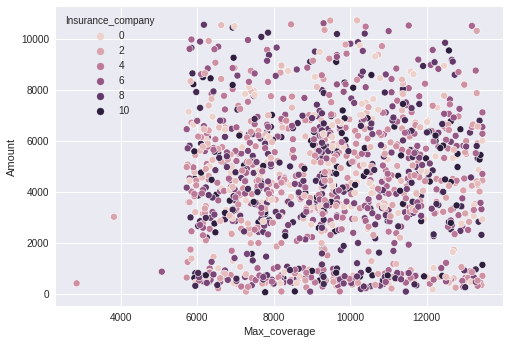

In [ ]:
sns.scatterplot(x= df_train['Max_coverage'], y= df_train['Amount'], hue= df_train['Insurance_company'])

The negative value or low value of R2 score is justified and i guess no model can fit over this noised data, and similary for other features as well, feature Amount is not showing any kind of correlation.

In [ ]:
df_test.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition
0,img_4538519.jpg,B,23600,590.0,2025-04-12,5978.0,1
1,img_7766002.jpg,C,28300,707.5,2028-08-24,7153.0,1
2,img_4637390.jpg,AC,43700,1092.5,2023-11-28,11003.0,1
3,img_4516108.jpg,BB,46100,1152.5,2028-02-04,11603.0,1
4,img_4517008.jpg,BB,40700,1017.5,2022-01-03,10253.0,1


In [ ]:
#label encoding the 'Insurance_company' feature in the testing data
df_test['Insurance_company'] = le.transform(df_test['Insurance_company'])
df_test.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition
0,img_4538519.jpg,3,23600,590.0,2025-04-12,5978.0,1
1,img_7766002.jpg,7,28300,707.5,2028-08-24,7153.0,1
2,img_4637390.jpg,2,43700,1092.5,2023-11-28,11003.0,1
3,img_4516108.jpg,4,46100,1152.5,2028-02-04,11603.0,1
4,img_4517008.jpg,4,40700,1017.5,2022-01-03,10253.0,1


In [ ]:
#taking required features for prediction
x_test = df_test[['Insurance_company', 'Max_coverage']]
x_test

,Insurance_company,Max_coverage
0,3,5978.00
1,7,7153.00
2,2,11003.00
3,4,11603.00
4,4,10253.00
...,...,...
595,3,7803.00
596,9,12903.00
597,6,23527.68
598,1,10728.00


In [ ]:
#normalizing the testing data
x_test = scaler1.transform(x_test)

since xgboost is better algorithm than randomforest so we will choose xgbbost with best params as our final predictor

In [ ]:
#predicting the target(amount) values
y_test = xgb.predict(x_test)

In [ ]:
y_test.shape

(600,)

In [ ]:
#preparing the predicted values for inverse normalization
y_test = np.asarray([y_test])

In [ ]:
#inverse normalizing the predicted value
y_test = scaler2.inverse_transform(y_test)
y_test.shape

(1, 600)

In [ ]:
#falttening the 2-D array
y_test = y_test.flatten()
y_test.shape

(600,)

In [ ]:
#setting the predicted values for non damaged cars to zero
for i in range(df_test.shape[0]):
    if df_test['Condition'][i] == 0:
        y_test[i] = 0

In [ ]:
#adding predicted values to dataframe
df_test['Amount'] = y_test

In [ ]:
#preparing data for final submission
sub = df_test[['Image_path','Condition','Amount']]
sub

,Image_path,Condition,Amount
0,img_4538519.jpg,1,4379.333627
1,img_7766002.jpg,1,4263.659531
2,img_4637390.jpg,1,4525.675909
3,img_4516108.jpg,1,4642.951749
4,img_4517008.jpg,1,4615.083209
...,...,...,...
595,img_7766518.jpg,1,4413.884337
596,img_4535713.jpg,1,3757.530385
597,img_4511787.jpg,1,3979.209798
598,img_4517592.jpg,1,4532.307831


In [ ]:
#convering final submission to .csv file
sub.to_csv('/content/Submission.csv',index= 0)